In [1]:
%pip install scipy yfinance matplotlib

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 22.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-any.whl size=139127 sha256=a765b88916b978f3a358abbfb527c70ab891d22172f90f4b3f302419114cd6d1
  Stored in directory: c:\users\ls5288_admin\appdata\local\pip\cache\wheels\43\ef\2d\2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb41588831
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [2]:
#%% Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
#%% Parâmetros e definição dos tickers do Ibovespa
# Lista com pelo menos 60 ações do Ibovespa (sufixo .SA para a B3)
tickers = [
    "ABEV3.SA","BTOW3.SA","B3SA3.SA","BBSE3.SA","BRML3.SA","BBDC3.SA","BBDC4.SA","BRAP4.SA","BBAS3.SA","BRKM5.SA",
    "BRFS3.SA","CCRO3.SA","CMIG4.SA","CIEL3.SA","CPLE6.SA","CSAN3.SA","CVCB3.SA","CYRE3.SA","ECOR3.SA","ELET3.SA",
    "ELET6.SA","EMBR3.SA","ENBR3.SA","EGIE3.SA","EQTL3.SA","ESTC3.SA","FIBR3.SA","FLRY3.SA","GGBR4.SA","GOAU4.SA",
    "GOLL4.SA","HYPE3.SA","IGTA3.SA","ITSA4.SA","ITUB4.SA","JBSS3.SA","KLBN11.SA","KROT3.SA","RENT3.SA","LAME4.SA",
    "LREN3.SA","MGLU3.SA","MRFG3.SA","MRVE3.SA","MULT3.SA","NATU3.SA","PCAR4.SA","PETR3.SA","PETR4.SA","BRDT3.SA",
    "QUAL3.SA","RADL3.SA","RAIL3.SA","SBSP3.SA","SANB11.SA","CSNA3.SA","SMLS3.SA","SUZB3.SA","TAEE11.SA","VIVT4.SA",
    "TIMP3.SA","UGPA3.SA","USIM5.SA","VALE3.SA","VVAR3.SA","WEGE3.SA"
]

# Taxa livre de risco anual (por exemplo, taxa Selic – parametrizada; valor hipotético)
rf_annual = 0.1375  # 13,75% ao ano

# Número de dias úteis por ano
trading_days = 252

#%% Baixar dados históricos para o período de treinamento
# Define o período de treinamento (por exemplo, últimos 5 anos)
end_train = datetime.date(2019, 6, 5)
start_train = end_train - datetime.timedelta(days=5*365)


In [4]:
# Baixar dados de fechamento ajustado
data_train = yf.download(tickers, start=start_train, end=end_train,auto_adjust=True)['Close']

# Remover colunas com muitos NaNs (se houver) e eliminar linhas com NaN
data_train = data_train.dropna(axis=1, how='any')
data_train = data_train.dropna()

print("Número de ativos com dados disponíveis:", data_train.shape[1])

#%% Cálculo dos retornos e parâmetros do modelo
# Calcula retornos diários
returns_train = data_train.pct_change().dropna()

# Retorno médio diário (vetor) e depois anualizado
mu_daily = returns_train.mean()
mu_annual = mu_daily * trading_days

# Matriz de covariância diária e depois anualizada
cov_daily = returns_train.cov()
cov_annual = cov_daily * trading_days

# Converter para arrays numpy (ordem consistente com tickers disponíveis)
assets = returns_train.columns.tolist()
mu = mu_annual[assets].values  # vetor de retornos anuais esperados
Sigma = cov_annual.loc[assets, assets].values  # matriz de covariância

# Taxa livre de risco diária
rf_daily = (1 + rf_annual)**(1/trading_days) - 1

# Número de ativos
n = len(mu)

[                       0%                       ]

[*********************100%***********************]  66 of 66 completed

17 Failed downloads:
['B3SA3.SA']: OperationalError('database is locked')
['NATU3.SA', 'CIEL3.SA', 'BRDT3.SA', 'ESTC3.SA', 'SMLS3.SA', 'KROT3.SA', 'IGTA3.SA', 'BRML3.SA', 'PCAR4.SA', 'TIMP3.SA', 'VIVT4.SA', 'ENBR3.SA', 'LAME4.SA', 'VVAR3.SA', 'BTOW3.SA']: YFTzMissingError('possibly delisted; no timezone found')
['FIBR3.SA']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


Número de ativos com dados disponíveis: 48


In [5]:
#%% Definição do problema de otimização
# Objetivo: Maximizar o Sharpe ratio do portfólio (excesso de retorno / volatilidade)
# O portfólio total inclui: alocação em ações (w) e o restante em caixa (que rende rf_daily)
# Note que o retorno do portfólio será:
#    Rp = sum(w_i * mu_i) + (1 - sum(w))*rf_annual   (anualizado)
# Assim, o excesso (acima do rf) vem só dos ativos:
#    Excess = sum(w_i*(mu_i - rf_annual))
# e a volatilidade é dada por sqrt(w^T Sigma w) (o caixa não contribui à volatilidade).

def sharpe_ratio(w, mu, Sigma, rf):
    # Evita divisão por zero (caso w seja zero)
    port_return = np.dot(w, mu - rf)
    port_vol = np.sqrt(np.dot(w, np.dot(Sigma, w)) + 1e-8)
    return port_return / port_vol

# Função objetivo (a ser minimizada: negativo do Sharpe)
def neg_sharpe(w, mu, Sigma, rf):
    return -sharpe_ratio(w, mu, Sigma, rf)


# Restrições:
eqty_portfolio_w = 0.95

# 1. Cada peso: 0 <= w_i <= 0.05
bounds = [(0, 0.05) for _ in range(n)]

# 2. Restrição de alocação total em ações: soma(w) entre 0.95 e 1.0
def constraint_min(w):
    return np.sum(w) - eqty_portfolio_w  # deve ser >= 0

def constraint_max(w):
    return 1.0 - np.sum(w)  # deve ser >= 0

constraints = [{'type': 'ineq', 'fun': constraint_min},
               {'type': 'ineq', 'fun': constraint_max}]

# Chute inicial: alocação igual que some 0.95
w0 = np.array([eqty_portfolio_w/n] * n)

#%% Otimização usando SLSQP
result = minimize(neg_sharpe, w0, args=(mu, Sigma, rf_annual), method='SLSQP',
                  bounds=bounds, constraints=constraints)

if not result.success:
    raise BaseException("Otimização não convergiu: " + result.message)

w_opt = result.x

In [6]:
# Exibe o Sharpe ratio otimizado
opt_sharpe = sharpe_ratio(w_opt, mu, Sigma, rf_annual)
print("Sharpe Ratio otimizado:", opt_sharpe)
print("Soma dos pesos (alocação em ações):", np.sum(w_opt))

#%% Ajuste dos pesos: arredondamento e aplicação da regra de corte
# Converter os pesos para porcentagem (0 a 100) e arredondar para 2 casas decimais
# Se um peso for menor que 0.01% (ou seja, 0.01) após arredondamento, consideramos 0%
w_opt_pct = np.round(w_opt * 100, 2)

# Aplicar a regra: se menor que 0.01, definir como 0
w_opt_pct[w_opt_pct < 0.01] = 0

# Recalcular a alocação total em ações (em %)
aloc_acoes = np.sum(w_opt_pct)
# O restante até 100% será o caixa
aloc_caixa = 100 - aloc_acoes

print("\nAlocação em ações (após arredondamento):")
df_weights = pd.DataFrame({'Ticker': assets, 'Peso (%)': w_opt_pct})
print(df_weights[df_weights['Peso (%)'] > 0].sort_values(by='Peso (%)', ascending=False))

print("\nTotal alocado em ações: {:.2f}%".format(aloc_acoes))
print("Alocação em caixa: {:.2f}% (rende a taxa Selic)".format(aloc_caixa))



Sharpe Ratio otimizado: 0.9435301853838977
Soma dos pesos (alocação em ações): 0.9500000001374543

Alocação em ações (após arredondamento):
       Ticker  Peso (%)
5    BRAP4.SA      5.00
7    BRKM5.SA      5.00
43  TAEE11.SA      5.00
42   SUZB3.SA      5.00
40  SANB11.SA      5.00
39   RENT3.SA      5.00
38   RADL3.SA      5.00
33   MRVE3.SA      5.00
31   MGLU3.SA      5.00
30   LREN3.SA      5.00
28   JBSS3.SA      5.00
21   FLRY3.SA      5.00
20   EQTL3.SA      5.00
18   ELET6.SA      5.00
17   ELET3.SA      5.00
16   EGIE3.SA      5.00
13   CVCB3.SA      5.00
47   WEGE3.SA      5.00
29  KLBN11.SA      1.77
41   SBSP3.SA      1.40
24   GOLL4.SA      1.29
46   VALE3.SA      0.54

Total alocado em ações: 95.00%
Alocação em caixa: 5.00% (rende a taxa Selic)


[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  1 of 1 completed


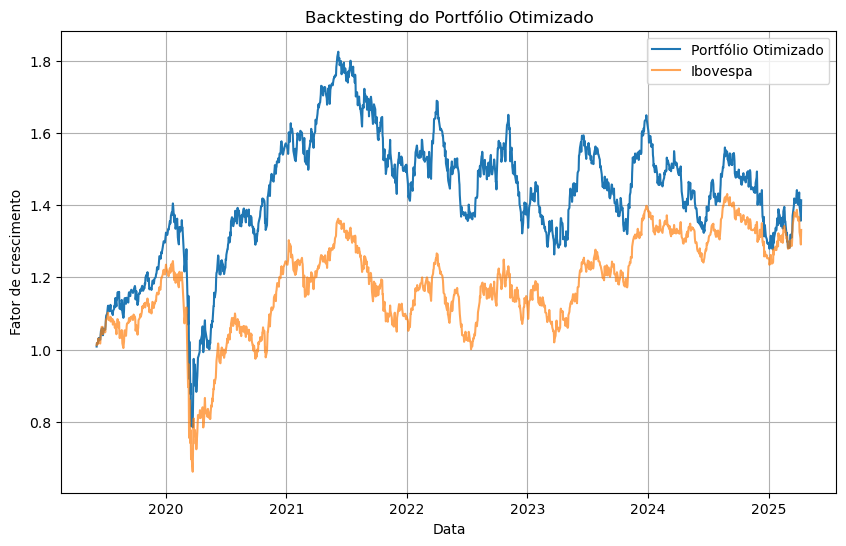

In [7]:
#%% Backtesting do portfólio otimizado
# Define o período de backtest (por exemplo, de 2023-01-01 até hoje)
start_bt = datetime.date(2019, 6, 5)
end_bt = datetime.date.today()

# Baixar dados históricos do período de backtesting
data_bt = yf.download(assets, start=start_bt, end=end_bt,auto_adjust=True)['Close']

# Certificar-se de que não há muitos NaNs e alinhar datas
data_bt = data_bt.dropna()

# Calcula retornos diários no período de backtesting
returns_bt = data_bt.pct_change().dropna()

# Recria o vetor de pesos (em proporção) a partir dos percentuais obtidos
# Atenção: se algum ativo teve peso 0 após arredondamento, ele não participa
w_opt_prop = w_opt_pct / 100  # agora em proporção (0 a 1)

# Seleciona apenas as colunas com peso positivo (os ativos efetivamente investidos)
ativos_invest = [asset for asset, peso in zip(assets, w_opt_prop) if peso > 0]
w_invest = np.array([peso for peso in w_opt_prop if peso > 0])

# Garantir que as datas do backtest incluam todos os ativos investidos
returns_bt = returns_bt[ativos_invest]

# Calcula o retorno diário do portfólio:
# R_portfolio = soma( peso_i * retorno_i ) + (1 - soma(pesos)) * rf_daily
port_returns = returns_bt.dot(w_invest) + (1 - np.sum(w_invest)) * rf_daily

# Calcula o acumulado do portfólio
cum_returns = (1 + port_returns).cumprod()

# Benchmark (Ibovespa)
ibov = yf.download("^BVSP", start_bt, end_bt,auto_adjust=True)['Close'].pct_change().dropna()
cum_ibov = (1 + ibov.reindex(port_returns.index, method='ffill')).cumprod()

# Plot do desempenho acumulado
plt.figure(figsize=(10, 6))
plt.plot(cum_returns.index, cum_returns, label="Portfólio Otimizado")
plt.plot(cum_ibov, label='Ibovespa', alpha=0.7)
plt.xlabel("Data")
plt.ylabel("Fator de crescimento")
plt.title("Backtesting do Portfólio Otimizado")
plt.legend()
plt.grid(True)
plt.show()